# This is the minimum Working Example to compute a multiple scattering experiment in the Q-Phase 

In [1]:
#!/usr/bin/env python2
# -*- coding: utf-8 -*-
"""
Created on Sat Jun 10 19:53:32 2017

@author: Bene

This file creates a fwd-model for the TESCAN Q-PHASE under 
multiple-scattering. It is majorly derived from  "LEarning approach for optical tomography"
U. S. Kamilov, BIG, EPFL, 2014.
"""
# %load_ext autoreload
import tensorflow as tf
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
from datetime import datetime

# load own functions
import src.model as mus
import src.tf_helper as tf_helper
import src.tf_generate_object as tf_go
import src.data as data
import src.optimization.tf_regularizers as reg


# change the following to %matplotlib notebook for interactive plotting
# %matplotlib inline

# Optionally, tweak styles.
mpl.rc('figure',  figsize=(8, 5))
mpl.rc('image', cmap='gray')


C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:72: UserWarning: h5py is running against HDF5 1.10.2 when it was built against 1.10.3, this may cause problems
  '{0}.{1}.{2}'.format(*version.hdf5_built_version_tuple)


# Define some optimization parameters 

In [2]:
'''Define some stuff related to infrastructure'''
mytimestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
savepath = os.path.join('./Data/DROPLETS/RESULTS/', mytimestamp)

# Create directory
try: 
    os.mkdir(savepath)
except(FileExistsError): 
    print('Folder exists already')

# Define parameters 
is_padding = False 
is_display = True
is_optimization = True 
is_optimization_psf = False
is_flip = False
is_measurement = False

# data files for parameters and measuremets 
if is_measurement:
    matlab_val_file = './Data/DROPLETS/allAmp_red.mat'      #'./Data/DROPLETS/allAmp_simu.npy' #
    matlab_par_file = './Data/DROPLETS/myParameterNew.mat'   
    matlab_val_name = 'allAmp_red'
    matlab_par_name = 'myParameterNew'    
else:
    matlab_val_file = './Data/DROPLETS/RESULTS/allAmp_simu.npy' #'./Data/DROPLETS/allAmp_simu.mat'      
    matlab_par_file = './Data/DROPLETS/myParameterNew.mat' 
    matlab_val_name = 'allAmp_red'
    matlab_par_name = 'myParameterNew'

# microscope parameters
zernikefactors = np.array((0,0,0,0,0,0,0,0,0)) # representing the 9 first zernike coefficients in noll-writings 
dn = .075 # refractive index of the object (difference)
NAc = .4

'''Define Optimization Parameters'''
my_learningrate = 1e-2  # learning rate
lambda_tv =  1e-3 # lambda for Total variation
lambda_gr = 0 # lambda for Goods Roughness 
lambda_pos = 0
lambda_neg = 10

Niter = 10000
Ndisplay = 10


'''START CODE'''
tf.reset_default_graph() # just in case there was an open session

# Generate Test-Object

In [3]:
''' File which stores the experimental parameters from the Q-PHASE setup 
    1.) Read in the parameters of the dataset ''' 
matlab_pars = data.import_parameters_mat(filename = matlab_par_file, matname='myParameterNew')

''' 2.) Read in the parameters of the dataset ''' 
if(matlab_val_file.find('mat')==-1):
    matlab_val = np.load(matlab_val_file)
else:
    matlab_val = data.import_realdata_h5(filename = matlab_val_file, matname='allAmp_red', is_complex=True)

if(is_flip):
    np_meas_raw = np.flip(matlab_val,0)
    print('Attention: We are flipping the data!')
else:
    np_meas_raw = matlab_val
print('do we need to flip the data?! -> Observe FFT!!')



''' Create the Model'''
muscat = mus.MuScatModel(matlab_pars, is_optimization=is_optimization, is_optimization_psf = is_optimization_psf)
muscat.Nx,muscat.Ny = int(np.squeeze(matlab_pars['Nx'].value)), int(np.squeeze(matlab_pars['Ny'].value))
muscat.shiftIcY=0
muscat.shiftIcX=0
muscat.dn = dn
muscat.NAc = NAc
muscat.dz = muscat.lambda0/4
print('Attention: Changed Z-sampling!!')

''' Adjust some parameters to fit it in the memory '''
muscat.mysize = (muscat.Nz,muscat.Nx,muscat.Ny) # ordering is (Nillu, Nz, Nx, Ny)

''' Create a 3D Refractive Index Distributaton as a artificial sample'''
obj = tf_go.generateObject(mysize=muscat.mysize, obj_dim=(muscat.dz,muscat.dx,muscat.dy), obj_type ='sphere', diameter = 1, dn = muscat.dn)

# introduce zernike factors here
muscat.zernikefactors = zernikefactors



do we need to flip the data?! -> Observe FFT!!
Assigned some value for dn which is not good!
Attention: Changed Z-sampling!!


# Compute the System's properties (e.g. Pupil function/Illumination Source, K-vectors, etc.)

In [4]:
''' Compute the systems model'''
muscat.computesys(obj, is_zernike=True, is_padding=is_padding, dropout_prob=1)
print(muscat.Ic.shape)

----------> Be aware: We are taking aberrations into account!
We are weighing the Intensity int the illu-pupil!
Shifting the illumination in X by: 0 Pixel
Shifting the illumination in Y by: 0 Pixel
Number of Illumination Angles / Plane waves: 29
(32, 32)


# Generate Computational Graph (fwd model)

Buildup Q-PHASE Model 


C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\tensor_util.py:416: ComplexWarning: Casting complex values to real discards the imaginary part
  nparray = values.astype(dtype.as_numpy_dtype)


----------> Bringing back Field to focus


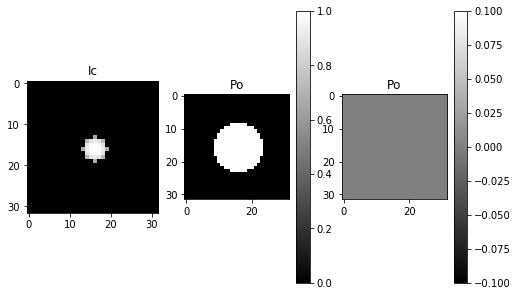

In [5]:
tf_fwd = muscat.computemodel()

if(is_display): 
    plt.subplot(131), plt.title('Ic'), plt.imshow(muscat.Ic)
    plt.subplot(132), plt.title('Po'),plt.imshow(np.fft.fftshift(np.abs(muscat.Po))), plt.colorbar()
    plt.subplot(133), plt.title('Po'),plt.imshow(np.fft.fftshift(np.angle(muscat.Po))), plt.colorbar(), plt.show()

# Define Optimizer and Cost-function

Now load data which has been saved previously (Optional!)

Evtl unwrap it!


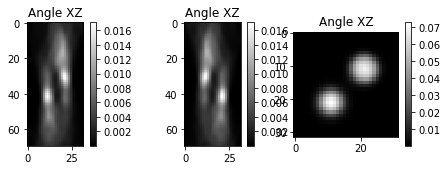

In [6]:
print('Evtl unwrap it!')

# this is the initial guess of the reconstruction
np_meas=np_meas_raw#*np.exp(1j*np.pi)

if(False):
    init_guess = np.angle(np_meas)
    init_guess = init_guess - np.min(init_guess)
    init_guess = init_guess**3
    init_guess = init_guess/np.max(init_guess)*muscat.dn
elif(True):
    init_guess = -np.abs(np_meas)
    init_guess = init_guess - np.min(init_guess)
    init_guess = init_guess**3
    init_guess = init_guess/np.max(init_guess)*muscat.dn
else:
    init_guess = np.random.randn(init_guess.shape[0],init_guess.shape[1],init_guess.shape[2])*muscat.dn

        

if(is_display): plt.subplot(231), plt.title('Angle XZ'),plt.imshow(init_guess[:,init_guess.shape[1]//2,:]), plt.colorbar()
if(is_display): plt.subplot(232), plt.title('Angle XZ'),plt.imshow(init_guess[:,:,init_guess.shape[1]//2]), plt.colorbar()
if(is_display): plt.subplot(233), plt.title('Angle XZ'),plt.imshow(init_guess[init_guess.shape[0]//2,:,:]), plt.colorbar(),plt.show()


# Optimize

# Estimate the Phase difference between Measurement and Simulation

In [7]:
#%%
'''Regression + Regularization'''
tf_meas = tf.placeholder(dtype=tf.complex64, shape=init_guess.shape)
             
'''Define Cost-function'''
tf_tvloss = lambda_tv*reg.tf_total_variation_regularization(muscat.TF_obj_phase, BetaVals = [muscat.dx,muscat.dy,muscat.dz], epsR=.001)  #Alernatively tf_total_variation_regularization # total_variation
#tf_posloss = lambda_neg*reg.posiminity(muscat.TF_obj_phase, minval=0)
#tf_negloss = lambda_pos*reg.posimaxity(muscat.TF_obj_phase, maxval=.2) 
tf_negsqrloss = lambda_neg*reg.RegularizeNegSqr(muscat.TF_obj_phase)
tf_globalphase = tf.Variable(0., tf.float32, name='var_phase')
tf_globalabs = tf.Variable(1., tf.float32, name='var_abs')# 
tf_fidelity = tf.reduce_sum(tf_helper.tf_abssqr(tf_fwd  - (tf_meas/tf.cast(tf.abs(tf_globalabs), tf.complex64)*tf.exp(1j*tf.cast(tf_globalphase, tf.complex64))))) # allow a global phase parameter to avoid unwrapping effects
tf_loss = tf_fidelity +  tf_negsqrloss + tf_tvloss #tf_negloss + tf_posloss + tf_tvloss

 # data fidelity
# TV regularization
# Positivity Penalty          
# eventually Goods Roughness reg
          
if(True):          
    '''Define Optimizer'''
    tf_learningrate = tf.placeholder(tf.float32, []) 
    tf_optimizer = tf.train.AdamOptimizer(tf_learningrate)
    tf_lossop = tf_optimizer.minimize(tf_loss)
else:
    tf_optimizer = tf.contrib.opt.ScipyOptimizerInterface(loss, options={'maxiter': 40},method='L-BFGS-B') # 'L-BFGS-B'
    tf_optimizer.minimize(sess)
    myloss=loss.eval()
    
''' Evaluate the model '''
sess = tf.Session()
sess.run(tf.global_variables_initializer())
if is_optimization:
    if is_padding:
        # Pad object with zeros along X/Y
        init_guess_tmp= np.zeros(muscat.mysize)# + 1j*np.zeros(muscat.mysize)
        init_guess_tmp[:,muscat.Nx//2-muscat.Nx//4:muscat.Nx//2+muscat.Nx//4, muscat.Ny//2-muscat.Ny//4:muscat.Ny//2+muscat.Ny//4] =init_guess
        init_guess = init_guess_tmp

    sess.run(tf.assign(muscat.TF_obj_phase, init_guess)); # assign abs of measurement as initial guess of 

my_fwd = sess.run(tf_fwd)#, feed_dict={muscat.TF_obj:obj})
mysize = my_fwd.shape



We use circular shift for the TV regularizer


My Init Phase is :-0.14344016


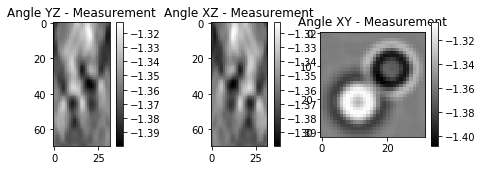

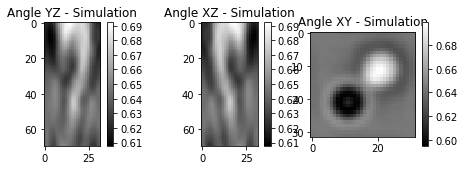

In [ ]:
# We assume, that there is a global phase mismatch between measurment and first estimate of the fwd model, this can be estimated by the difference of mean phase of the two
# subtracting the mean phase from either measurement or the fwd model could help to speed up the optimization
# this is the initial guess of the reconstruction
np_meas = matlab_val
myinitphase = np.mean(np.angle(np_meas))-np.mean(np.angle(my_fwd))
print('My Init Phase is :'+str(myinitphase))
np_meas=np_meas*np.exp(-1j*(myinitphase+2)) # subtract globaphase - anyway we want to optimize for that, but now the global phase can be assumed to be 0 initally
if(is_display): plt.subplot(231), plt.title('Angle YZ - Measurement'),plt.imshow(np.angle(np_meas)[:,mysize[1]//2,:]), plt.colorbar()#, plt.show()
if(is_display): plt.subplot(232), plt.title('Angle XZ - Measurement'),plt.imshow(np.angle(np_meas)[:,:,mysize[2]//2]), plt.colorbar()#, plt.show()
if(is_display): plt.subplot(233), plt.title('Angle XY - Measurement'),plt.imshow(np.angle(np_meas)[mysize[0]//2,:,:]), plt.colorbar(), plt.show()

if(is_display): plt.subplot(234), plt.title('Angle YZ - Simulation'),plt.imshow(np.angle(my_fwd)[:,mysize[1]//2,:]), plt.colorbar()#, plt.show()
if(is_display): plt.subplot(235), plt.title('Angle XZ - Simulation'),plt.imshow(np.angle(my_fwd)[:,:,mysize[2]//2]), plt.colorbar()#, plt.show()
if(is_display): plt.subplot(236), plt.title('Angle XY - Simulation'),plt.imshow(np.angle(my_fwd)[mysize[0]//2,:,:]), plt.colorbar(), plt.show()

# assert some memory 
iter_last = 0
mylosslist = []
myfidelitylist = []
myposlosslist = []
myneglosslist = []
mytvlosslist = []
result_phaselist = []
result_reallist = []
globalphaselist = []
globalabslist = []

In [ ]:
#%%
''' Optimize the model '''
print('Start optimizing')
np_meas = matlab_val # use the previously simulated data

for iterx in range(iter_last,Niter):
    if iterx == 1000:
        my_learningrate = my_learningrate*.1
    # try to optimize
    
    if(iterx==0 or not np.mod(iterx, Ndisplay)):
        my_opt, my_res_phase, my_loss, my_fidelity, my_negloss, my_tvloss, myglobalphase, myglobalabs, myfwd =  \
            sess.run([tf_lossop, muscat.TF_obj_phase, tf_loss, tf_fidelity, tf_negsqrloss, tf_tvloss, tf_globalphase, tf_globalabs, tf_fwd], \
                     feed_dict={tf_meas:np_meas, tf_learningrate:my_learningrate})

        print('Loss@'+str(iterx)+': ' + str(my_loss) + ' - Fid: '+str(my_fidelity)+', Neg: '+str(my_negloss)+', TV: '+str(my_tvloss)+' G-Phase:'+str(myglobalphase)+' G-ABS: '+str(myglobalabs))        
        mylosslist.append(my_loss)
        myfidelitylist.append(my_fidelity)
        myneglosslist.append(my_negloss)
        mytvlosslist.append(my_tvloss)
        result_phaselist.append(my_res_phase)
        globalphaselist.append(myglobalphase)
        globalabslist.append(myglobalabs)  
        
        if(is_display): plt.subplot(234), plt.title('Angle XZ'),plt.imshow(np.angle(myfwd)[:,myfwd.shape[1]//2,:]), plt.colorbar()#, plt.show()
        if(is_display): plt.subplot(235), plt.title('Angle XZ'),plt.imshow(np.angle(myfwd)[:,:,myfwd.shape[2]//2]), plt.colorbar()#, plt.show()
        if(is_display): plt.subplot(236), plt.title('Angle XY'),plt.imshow(np.angle(myfwd)[myfwd.shape[0]//2,:,:]), plt.colorbar(), plt.show()

    else:
        sess.run([tf_lossop], feed_dict={tf_meas:np_meas, tf_learningrate:my_learningrate})
        #plt.imshow(np.abs(my_res[:,50,:]))
        

#save stack to disk
#sktiff.imsave(savepath+'Obj_Reconstruction.tif', np.array(resultlist), compress=6, metadata={'axes': 'TZXY'})

Start optimizing
Loss@0: 1396.6593 - Fid: 1391.5023, Neg: 0.0, TV: 5.1569376 G-Phase:0.009999999 G-ABS: 1.01
Loss@10: 970.0695 - Fid: 684.4678, Neg: 260.90744, TV: 24.694302 G-Phase:0.011464376 G-ABS: 1.0984253
Loss@20: 756.84064 - Fid: 419.13913, Neg: 310.69064, TV: 27.010853 G-Phase:0.0090243 G-ABS: 1.1650188
Loss@30: 344.93356 - Fid: 158.48438, Neg: 162.82898, TV: 23.620203 G-Phase:0.014629951 G-ABS: 1.1989582
Loss@40: 152.9966 - Fid: 84.49257, Neg: 49.057335, TV: 19.446701 G-Phase:0.018086102 G-ABS: 1.2158573
Loss@50: 65.754166 - Fid: 35.969204, Neg: 12.73526, TV: 17.049698 G-Phase:0.018424695 G-ABS: 1.2230957
Loss@60: 42.881428 - Fid: 23.462814, Neg: 3.7698123, TV: 15.648802 G-Phase:0.019199722 G-ABS: 1.2259622
Loss@70: 31.190514 - Fid: 15.050167, Neg: 1.5243278, TV: 14.616017 G-Phase:0.020153627 G-ABS: 1.2264899
Loss@80: 25.667582 - Fid: 11.188214, Neg: 0.78563356, TV: 13.693733 G-Phase:0.021028213 G-ABS: 1.2262268
Loss@90: 22.45365 - Fid: 9.157824, Neg: 0.44356173, TV: 12.852264

# Display result - FFT

In [ ]:
iter_last = iterx
#%% Display the results
is_display=True
myfwd, mymeas, my_res_phase = sess.run([tf_fwd, tf_meas, muscat.TF_obj_phase], feed_dict={tf_meas:np_meas})
        
if(is_display): plt.subplot(231),plt.title('FFT, Meas, YZ'), plt.imshow(np.abs(np.fft.fftshift(np.fft.fftn(mymeas))**.2)[:,mymeas.shape[1]//2,:]), plt.colorbar()#, plt.show()    
if(is_display): plt.subplot(232),plt.title('FFT, Meas, XZ'), plt.imshow(np.abs(np.fft.fftshift(np.fft.fftn(mymeas))**.2)[mymeas.shape[0]//2,:,:]), plt.colorbar()#, plt.show()   
if(is_display): plt.subplot(233),plt.title('FFT, Meas, XY'), plt.imshow(np.abs(np.fft.fftshift(np.fft.fftn(mymeas))**.2)[:,:,mymeas.shape[2]//2]), plt.colorbar()#, plt.show()     
if(is_display): plt.subplot(234),plt.title('FFT, Meas, YZ'), plt.imshow(np.abs(np.fft.fftshift(np.fft.fftn(myfwd))**.2)[:,myfwd.shape[1]//2,:]), plt.colorbar()#, plt.show()
if(is_display): plt.subplot(235),plt.title('FFT, Meas, XZ'), plt.imshow(np.abs(np.fft.fftshift(np.fft.fftn(myfwd))**.2)[myfwd.shape[0]//2,:,:]), plt.colorbar()#, plt.show()    
if(is_display): plt.subplot(236),plt.title('FFT, Meas, XY'), plt.imshow(np.abs(np.fft.fftshift(np.fft.fftn(myfwd))**.2)[:,:,myfwd.shape[2]//2]), plt.colorbar(), plt.show()    
if(is_display): plt.subplot(236),plt.title('FFT, Meas, XY'), plt.imshow(np.abs(np.fft.fftshift(np.fft.fftn(myfwd))**.2)[:,:,myfwd.shape[2]//2]), plt.colorbar(), plt.show()    


In [ ]:
# This is the reconstruction
if(is_display): plt.subplot(231), plt.title('ABS XZ'),plt.imshow(np.abs(myfwd)[:,myfwd.shape[1]//2,:]), plt.colorbar()#, plt.show()
if(is_display): plt.subplot(232), plt.title('ABS XZ'),plt.imshow(np.abs(myfwd)[:,:,myfwd.shape[2]//2]), plt.colorbar()#, plt.show()
if(is_display): plt.subplot(233), plt.title('ABS XY'),plt.imshow(np.abs(myfwd)[myfwd.shape[0]//2,:,:]), plt.colorbar()#, plt.show()

if(is_display): plt.subplot(234), plt.title('Angle XZ'),plt.imshow(np.angle(myfwd)[:,myfwd.shape[1]//2,:]), plt.colorbar()#, plt.show()
if(is_display): plt.subplot(235), plt.title('Angle XZ'),plt.imshow(np.angle(myfwd)[:,:,myfwd.shape[2]//2]), plt.colorbar()#, plt.show()
if(is_display): plt.subplot(236), plt.title('Angle XY'),plt.imshow(np.angle(myfwd)[myfwd.shape[0]//2,:,:]), plt.colorbar(), plt.show()

# This is the measurment
if(is_display): plt.subplot(231), plt.title('ABS XZ'),plt.imshow(np.abs(np_meas)[:,np_meas.shape[1]//2,:]), plt.colorbar()#, plt.show()
if(is_display): plt.subplot(232), plt.title('ABS XZ'),plt.imshow(np.abs(np_meas)[:,:,np_meas.shape[2]//2]), plt.colorbar()#, plt.show()
if(is_display): plt.subplot(233), plt.title('ABS XY'),plt.imshow(np.abs(np_meas)[np_meas.shape[0]//2,:,:]), plt.colorbar()#, plt.show()

if(is_display): plt.subplot(234), plt.title('Angle XZ'),plt.imshow(np.angle(np_meas)[:,np_meas.shape[1]//2,:]), plt.colorbar()#, plt.show()
if(is_display): plt.subplot(235), plt.title('Angle XZ'),plt.imshow(np.angle(np_meas)[:,:,np_meas.shape[2]//2]), plt.colorbar()#, plt.show()
if(is_display): plt.subplot(236), plt.title('Angle XY'),plt.imshow(np.angle(np_meas)[np_meas.shape[0]//2,:,:]), plt.colorbar(), plt.show()

# diplay the error over time
plt.subplot(241), plt.title('Error/Cost-function'), plt.plot(np.log(np.array(mylosslist)))#, plt.show()
plt.subplot(242), plt.title('Fidelity-function'), plt.plot(np.log(np.array(myfidelitylist)))#, plt.show()
#plt.subplot(243), plt.title('Pos-loss-function'), plt.plot(np.array(myposlosslist))#, plt.show()
plt.subplot(244), plt.title('Neg-loss-function'), plt.plot(np.array(myneglosslist))#, plt.show()
plt.subplot(245), plt.title('TV-loss-function'), plt.plot(np.array(mytvlosslist))#, plt.show()
plt.subplot(246), plt.title('Global Phase'), plt.plot(np.array(globalphaselist))#, plt.show()
plt.subplot(247), plt.title('Global ABS'), plt.plot(np.array(globalabslist)), plt.show()



# Display Result Refractive index

# Display results ABS/Angle - FWD model

In [ ]:
if(is_display): plt.subplot(131), plt.title('Result Phase: XZ'),plt.imshow(my_res_phase[:,my_res_phase.shape[1]//2,:]), plt.colorbar()#, plt.show()
if(is_display): plt.subplot(132), plt.title('Result Phase: XZ'),plt.imshow(my_res_phase[:,:,my_res_phase.shape[2]//2]), plt.colorbar()#, plt.show()
if(is_display): plt.subplot(133), plt.title('Result Phase: XY'),plt.imshow(my_res_phase[my_res_phase.shape[0]//2,:,:]), plt.colorbar(), plt.show()


In [ ]:
#plt.subplot(121), plt.imshow(np.angle(sess.run(muscat.TF_Po.eval)))
print(np.real(sess.run(muscat.TF_zernikefactors)))
plt.subplot(121), plt.title('Po Phase'), plt.imshow(np.fft.fftshift(np.angle(sess.run(muscat.TF_Po_aberr)))), plt.colorbar()
plt.subplot(122), plt.title('Po abs'), plt.imshow(np.fft.fftshift(np.abs(sess.run(muscat.TF_Po_aberr)))), plt.colorbar(), plt.show()

#np.save(savepath+'/myrefractiveindex.npy',np.array(resultlist))
data.export_realdatastack_h5(savepath+'/myrefractiveindex.h5', 'temp', np.array(result_phaselist))

# Display recovered pupil

# Save results

# %% save the results
np.save(savepath+'/rec.npy', my_res)
data.saveHDF5(my_res, savepath+'/Obj_Reconstruction.h5')
data.saveHDF5(np.abs(np_meas), savepath+'/Amplitude_abs.h5')
data.saveHDF5(np.angle(np_meas), savepath+'/Amplitude_angle.h5')